# Proyecto_X_NLP – Preprocesamiento del texto (YouToxic)

En este notebook vamos a transformar el dataset original en una versión "clean"
lista para:

- Modelos **clásicos** (TF-IDF + regresión logística, SVM, etc.).
- Modelos **modernos** (transformers tipo BERT).

Objetivos:

1. Eliminar duplicados y asegurar calidad del texto.
2. Normalizar y limpiar el texto (menciones, emojis, números, etc.).
3. Generar dos versiones de texto:
   - `text_basic`: limpieza suave, compatible con modelos modernos.
   - `text_classic`: texto normalizado para TF-IDF y similares.
4. Crear *features* numéricas útiles (longitud, mayúsculas, exclamaciones, etc.).
5. Seleccionar etiquetas útiles y descartar columnas sin información.
6. Guardar un dataset limpio: `data/preprocessing_data/youtoxic_english_1000_clean.csv`.


### 1. Importación de librerías y configuración

En esta sección:

- Importamos librerías de manipulación de datos, NLP y manejo de emojis.
- Descargamos los recursos necesarios de NLTK.
- Dejamos preparado el entorno para las funciones de limpieza posteriores.


In [1]:
# === 1. Imports and basic configuration ======================================
import re                    # Regular expressions for text cleaning
import string                # String utilities (e.g. punctuation list)
from collections import Counter  # Frequency counting if needed
from pathlib import Path     # Filesystem paths

import pandas as pd          # Data manipulation and analysis
import numpy as np           # Numerical utilities

import nltk                  # NLP toolkit
from nltk.corpus import stopwords  # Stopwords lists (English, Spanish, ...)
from nltk.tokenize import word_tokenize  # Basic word tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer  # Stemming and lemmatization

import emoji                 # Emoji handling: convert emojis to text

from IPython.display import display, Markdown  # Rich Markdown output in notebook

import warnings
warnings.filterwarnings("ignore")

# Download NLTK resources (only first time)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

display(Markdown(r"""
### 1. Librerías de preprocesamiento

En esta celda hemos:

- Importado:
  - `pandas` / `numpy` para manipular el dataset.
  - `re` y `string` para limpiar texto (puntuación, patrones, etc.).
  - `nltk` (stopwords, tokenización, stemming, lematización).
  - `emoji` para traducir emojis a texto legible.
- Descargado recursos de NLTK:
  - *stopwords* en varios idiomas.
  - *wordnet* para lematización en inglés.

La idea es que estas funciones sean **lo más genéricas posible**, de modo que
sirvan tanto para textos en inglés como, con ligeros ajustes, para textos en español.
"""))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeder\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeder\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yeder\AppData\Roaming\nltk_data...



### 1. Librerías de preprocesamiento

En esta celda hemos:

- Importado:
  - `pandas` / `numpy` para manipular el dataset.
  - `re` y `string` para limpiar texto (puntuación, patrones, etc.).
  - `nltk` (stopwords, tokenización, stemming, lematización).
  - `emoji` para traducir emojis a texto legible.
- Descargado recursos de NLTK:
  - *stopwords* en varios idiomas.
  - *wordnet* para lematización en inglés.

La idea es que estas funciones sean **lo más genéricas posible**, de modo que
sirvan tanto para textos en inglés como, con ligeros ajustes, para textos en español.


### 2. Carga del dataset original

Cargamos de nuevo el CSV original (`youtoxic_english_1000.csv`) desde la carpeta
`data` en la raíz del proyecto (al mismo nivel que `backend`):

- Verificamos la ruta automáticamente.
- Hacemos una copia de trabajo (`df_raw`).


In [2]:
# === 2. Load original dataset ===============================================

# Detect project root
notebook_dir = Path.cwd()

if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent.parent
elif notebook_dir.name == "backend":
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

data_path = project_root / "data" / "youtoxic_english_1000.csv"

print(f"📂 Project root detected as: {project_root}")
print(f"📂 Loading dataset from: {data_path}")

if not data_path.exists():
    raise FileNotFoundError(
        f"Dataset not found at {data_path}.\n"
        "Comprueba que la carpeta 'data' está en la raíz del proyecto y que\n"
        "el fichero 'youtoxic_english_1000.csv' está dentro de ella."
    )

df_raw = pd.read_csv(data_path)
df = df_raw.copy()

display(Markdown(rf"""
### 2. Dataset cargado

- Fichero cargado: **`data/youtoxic_english_1000.csv`**
- Número de filas: **{len(df)}**
- Número de columnas: **{len(df.columns)}**

A partir de aquí trabajaremos con una copia (`df`) para dejar intacto
el dataset original (`df_raw`).
"""))


📂 Project root detected as: c:\Users\yeder\Documents\Factoria F5 Bootcamp IA\Proyecto_X_NLP_G4
📂 Loading dataset from: c:\Users\yeder\Documents\Factoria F5 Bootcamp IA\Proyecto_X_NLP_G4\data\youtoxic_english_1000.csv



### 2. Dataset cargado

- Fichero cargado: **`data/youtoxic_english_1000.csv`**
- Número de filas: **1000**
- Número de columnas: **15**

A partir de aquí trabajaremos con una copia (`df`) para dejar intacto
el dataset original (`df_raw`).


### 3. Eliminación de textos duplicados

En el EDA vimos que había algunos **comentarios repetidos** (mismo texto, mismas
etiquetas).

En esta sección:

- Localizamos los textos duplicados.
- Mostramos qué etiquetas tienen.
- Eliminamos los duplicados manteniendo sólo una copia de cada texto.

Así evitamos **sobre-representar** esos pocos ejemplos en el entrenamiento.


In [3]:
# === 3. Remove duplicated texts =============================================

print("=" * 80)
print("1. ELIMINACIÓN DE DUPLICADOS DE TEXTO")
print("=" * 80)

n_before = len(df)
n_dup_text = df["Text"].duplicated().sum()

print(f"\n📊 ANTES DE LIMPIAR:")
print(f"   Total de comentarios: {n_before:,}")
print(f"   Comentarios duplicados (texto): {n_dup_text}")

# Show duplicated texts if any
if n_dup_text > 0:
    # All rows with duplicated text (including originals)
    dupl_rows = df[df["Text"].duplicated(keep=False)].copy()
    
    # Identify label columns
    label_cols = [c for c in df.columns if c.startswith("Is")]
    
    print("\n🔍 COMENTARIOS DUPLICADOS (mismo texto, posibles cambios de mayúsculas):")
    display(dupl_rows[["Text", *label_cols]].sort_values("Text").head(10))
    
    # Drop duplicates based on Text, keep the first
    df = df.drop_duplicates(subset=["Text"], keep="first").copy()

n_after = len(df)
print(f"\n✅ DESPUÉS DE LIMPIAR:")
print(f"   Total de comentarios: {n_after:,}")
print(f"   Comentarios eliminados: {n_before - n_after}")

display(Markdown(rf"""
### 3. Resultados: eliminación de textos duplicados

- Comentarios iniciales: **{n_before}**
- Comentarios con texto duplicado: **{n_dup_text}**
- Comentarios tras eliminar duplicados: **{n_after}**
- Eliminados: **{n_before - n_after}** filas.

Los duplicados mostrados arriba tenían **el mismo texto** y **las mismas etiquetas `Is...`**,
por lo que no aportaban información nueva.  
Mantener sólo una copia de cada texto:

- Reduce el riesgo de **sobreajuste** a esos ejemplos.
- Mantiene el equilibrio de clases prácticamente igual.
"""))


1. ELIMINACIÓN DE DUPLICADOS DE TEXTO

📊 ANTES DE LIMPIAR:
   Total de comentarios: 1,000
   Comentarios duplicados (texto): 3

🔍 COMENTARIOS DUPLICADOS (mismo texto, posibles cambios de mayúsculas):


,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
592,RUN THEM OVER,True,True,False,True,False,False,False,False,False,False,False,False
699,RUN THEM OVER,True,True,False,True,False,False,False,False,False,False,False,False
642,run them over,True,True,True,False,False,False,False,False,False,False,False,False
657,run them over,True,True,False,True,False,False,False,False,False,False,False,False
677,run them over,True,True,False,True,False,False,False,False,False,False,False,False



✅ DESPUÉS DE LIMPIAR:
   Total de comentarios: 997
   Comentarios eliminados: 3



### 3. Resultados: eliminación de textos duplicados

- Comentarios iniciales: **1000**
- Comentarios con texto duplicado: **3**
- Comentarios tras eliminar duplicados: **997**
- Eliminados: **3** filas.

Los duplicados mostrados arriba tenían **el mismo texto** y **las mismas etiquetas `Is...`**,
por lo que no aportaban información nueva.  
Mantener sólo una copia de cada texto:

- Reduce el riesgo de **sobreajuste** a esos ejemplos.
- Mantiene el equilibrio de clases prácticamente igual.


### 4. Definición de funciones de limpieza y normalización

En esta sección definimos funciones reutilizables para:

1. **Limpieza básica**:
   - Eliminar menciones, hashtags.
   - Normalizar espacios.
2. **Traducción de emojis a texto**:
   - `😂` → `"face with tears of joy"`.
3. **Normalización avanzada**:
   - Minúsculas, números, puntuación.
4. **Stopwords, stemming y lematización**:
   - Soporte principal para inglés.
   - Preparado para extender a español (por ejemplo, con SnowballStemmer).


In [4]:
# === 4. Text preprocessing utility functions ================================

def translate_emojis_to_text(text: str) -> str:
    """
    Replace emojis by textual descriptions using emoji.demojize.
    Example: 😂 -> :face_with_tears_of_joy: -> 'face with tears of joy'.
    
    This works for any language in the surrounding text, because emojis are
    language-independent; we just add English tokens describing their meaning.
    """
    text = str(text)
    # Convert emojis to :emoji_name:
    text = emoji.demojize(text)
    # Replace :emoji_name: by 'emoji_name' (with spaces instead of underscores)
    text = re.sub(
        r":([a-zA-Z0-9_]+):",
        lambda m: " " + m.group(1).replace("_", " ") + " ",
        text
    )
    # Normalize multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def clean_text_basic(text: str) -> str:
    """
    Limpieza básica del texto.
    - Conserva URLs (no las eliminamos)
    - Elimina menciones (@usuario)
    - Elimina el símbolo # pero mantiene la palabra del hashtag
    - Traduce emojis a texto (si lo deseas mantener)
    - Normaliza espacios en blanco
    """
    # Ensure input is always a string
    text = str(text)

    # ⚠️ IMPORTANT: we keep URLs, so we DO NOT remove http/https patterns here
    # If we wanted to normalize them, we could replace them by a token like <URL>

    # 1) Remove mentions (@user)
    text = re.sub(r"@\w+", "", text)  # remove user mentions

    # 2) Remove only the "#" symbol but keep the hashtag word
    text = re.sub(r"#(\w+)", r"\1", text)  # keep the word without "#"

    # 3) (Opcional) traducir emojis a texto: aquí podrías llamar a una función
    #    tipo `emoji.demojize(text)` si quieres convertir 😊 -> :smiling_face:
    #    De momento, lo dejamos como está.

    # 4) Normalize whitespace (spaces, tabs, newlines)
    text = re.sub(r"\s+", " ", text).strip()  # collapse multiple spaces

    return text



def clean_text_advanced(
    text: str,
    lowercase: bool = True,
    remove_numbers: bool = True,
    remove_punctuation: bool = True,
) -> str:
    """
    Advanced normalization:
    - Optional lowercase
    - Optional removal of digits
    - Optional removal of punctuation
    - Normalize spaces
    """
    text = str(text)
    
    if lowercase:
        text = text.lower()
    
    if remove_numbers:
        text = re.sub(r"\d+", " ", text)
    
    if remove_punctuation:
        text = text.translate(str.maketrans("", "", string.punctuation))
    
    text = re.sub(r"\s+", " ", text).strip()
    return text


def get_stopwords(language: str = "english") -> set:
    """
    Return stopwords set for given language. If language is not available,
    fallback to English.
    """
    try:
        return set(stopwords.words(language))
    except OSError:
        # Fallback to English if language is not found
        return set(stopwords.words("english"))


def remove_stopwords(text: str, language: str = "english") -> str:
    """
    Remove stopwords for the given language.
    """
    sw = get_stopwords(language)
    tokens = text.split()
    filtered = [t for t in tokens if t.lower() not in sw]
    return " ".join(filtered)


def apply_stemming(text: str, language: str = "english") -> str:
    """
    Apply stemming:
    - English: PorterStemmer
    - Spanish: SnowballStemmer('spanish')
    (Can be extended for more languages.)
    """
    tokens = text.split()
    
    if language == "spanish":
        stemmer = SnowballStemmer("spanish")
    else:
        stemmer = PorterStemmer()
    
    stemmed = [stemmer.stem(t) for t in tokens]
    return " ".join(stemmed)


def apply_lemmatization(text: str, language: str = "english") -> str:
    """
    Apply lemmatization:
    - English: WordNetLemmatizer (requires POS tagging for best results).
    - For other languages we currently return the text unchanged, because
      proper lemmatization requires language-specific resources (e.g. spaCy).
    """
    tokens = text.split()
    
    if language != "english":
        # Placeholder: for Spanish you would typically use spaCy/Stanza
        return text
    
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)


display(Markdown(r"""
### 4. Funciones de limpieza definidas

- `clean_text_basic`:
  - Limpieza suave, pensada para **modelos modernos** (BERT, etc.).
  - Conserva casi toda la información semántica, sólo quita ruido evidente.
- `clean_text_advanced`:
  - Normalización más agresiva (minúsculas, sin números, sin puntuación).
  - Pensada para alimentar **TF-IDF / Bag-of-Words**.
- `translate_emojis_to_text`:
  - Convierte emojis en descripciones de texto en inglés, válidas tanto si el
    resto del texto está en inglés como en español.
- `remove_stopwords`, `apply_stemming`, `apply_lemmatization`:
  - Preparadas para inglés; se pueden extender a español cuando se integren
    recursos específicos (por ejemplo, spaCy para lematización en español).
"""))



### 4. Funciones de limpieza definidas

- `clean_text_basic`:
  - Limpieza suave, pensada para **modelos modernos** (BERT, etc.).
  - Conserva casi toda la información semántica, sólo quita ruido evidente.
- `clean_text_advanced`:
  - Normalización más agresiva (minúsculas, sin números, sin puntuación).
  - Pensada para alimentar **TF-IDF / Bag-of-Words**.
- `translate_emojis_to_text`:
  - Convierte emojis en descripciones de texto en inglés, válidas tanto si el
    resto del texto está en inglés como en español.
- `remove_stopwords`, `apply_stemming`, `apply_lemmatization`:
  - Preparadas para inglés; se pueden extender a español cuando se integren
    recursos específicos (por ejemplo, spaCy para lematización en español).


### 5. Creación de `text_basic` y `text_classic`

Ahora generamos las columnas principales que usaremos en los modelos:

- `text_basic`:
  - Texto original con limpieza básica y emojis convertidos a texto.
  - Mantiene puntuación y mayúsculas (útil para transformers).
- `text_classic`:
  - `text_basic` → minúsculas → sin números → sin puntuación
  - Sin stopwords → lematización.
  - Ideal para TF-IDF y modelos clásicos.

Además calculamos:

- `text_len_classic`: longitud en caracteres de `text_classic`.
- `word_count_classic`: número de palabras en `text_classic`.


In [5]:
# === 5. Generate text_basic and text_classic =================================

print("=" * 80)
print("2. CREACIÓN DE COLUMNAS DE TEXTO PROCESADO")
print("=" * 80)

# 1) text_basic: soft cleaning + emojis -> text
df["text_basic"] = df["Text"].apply(clean_text_basic)

# 2) text_classic: stronger normalization for classical models
#    language='english' because this dataset está en inglés
df["text_classic"] = (
    df["text_basic"]
    .apply(lambda x: clean_text_advanced(x, lowercase=True,
                                         remove_numbers=True,
                                         remove_punctuation=True))
    .apply(lambda x: remove_stopwords(x, language="english"))
    .apply(lambda x: apply_lemmatization(x, language="english"))
)

# 3) Length features based on text_classic
df["text_len_classic"] = df["text_classic"].astype(str).str.len()
df["word_count_classic"] = df["text_classic"].astype(str).str.split().str.len()

display(Markdown(r"""
### 5. Resultados: columnas de texto procesado

Se han creado las siguientes columnas nuevas:

- **`text_basic`**  
  - Texto original limpiado (sin menciones, etc.) y con emojis convertidos a texto.
  - Conserva la estructura y casi todo el contexto original.

- **`text_classic`**  
  - Versión normalizada para modelos clásicos:
    - Minúsculas, sin números ni puntuación.
    - Sin *stopwords* en inglés.
    - Con lematización (WordNet).

- **`text_len_classic`**  
  - Longitud del texto en caracteres.

- **`word_count_classic`**  
  - Número de palabras en `text_classic`.

Estas columnas son las que utilizaremos para generar el fichero
`youtoxic_english_1000_clean.csv`, listo para vectorización y modelado.
"""))


2. CREACIÓN DE COLUMNAS DE TEXTO PROCESADO



### 5. Resultados: columnas de texto procesado

Se han creado las siguientes columnas nuevas:

- **`text_basic`**  
  - Texto original limpiado (sin menciones, etc.) y con emojis convertidos a texto.
  - Conserva la estructura y casi todo el contexto original.

- **`text_classic`**  
  - Versión normalizada para modelos clásicos:
    - Minúsculas, sin números ni puntuación.
    - Sin *stopwords* en inglés.
    - Con lematización (WordNet).

- **`text_len_classic`**  
  - Longitud del texto en caracteres.

- **`word_count_classic`**  
  - Número de palabras en `text_classic`.

Estas columnas son las que utilizaremos para generar el fichero
`youtoxic_english_1000_clean.csv`, listo para vectorización y modelado.


### 6. Features adicionales: mayúsculas, exclamaciones y palabras de odio

Aprovechamos lo visto en el EDA para generar variables numéricas que capturan:

- Proporción de mayúsculas (`uppercase_ratio`).
- Número de signos de exclamación (`exclamation_count`).
- Número de palabras de odio (`hate_words_count`).

Estas features se pueden concatenar a TF-IDF u otras representaciones.


📊 Descriptive statistics for style features:


,uppercase_ratio,exclamation_count,hate_words_count
count,997.000000,997.000000,997.000000
mean,0.052071,0.361083,0.625878
std,0.105411,1.104032,1.287666
min,0.000000,0.000000,0.000000
25%,0.013699,0.000000,0.000000
50%,0.025316,0.000000,0.000000
75%,0.050000,0.000000,1.000000
max,0.875000,12.000000,18.000000


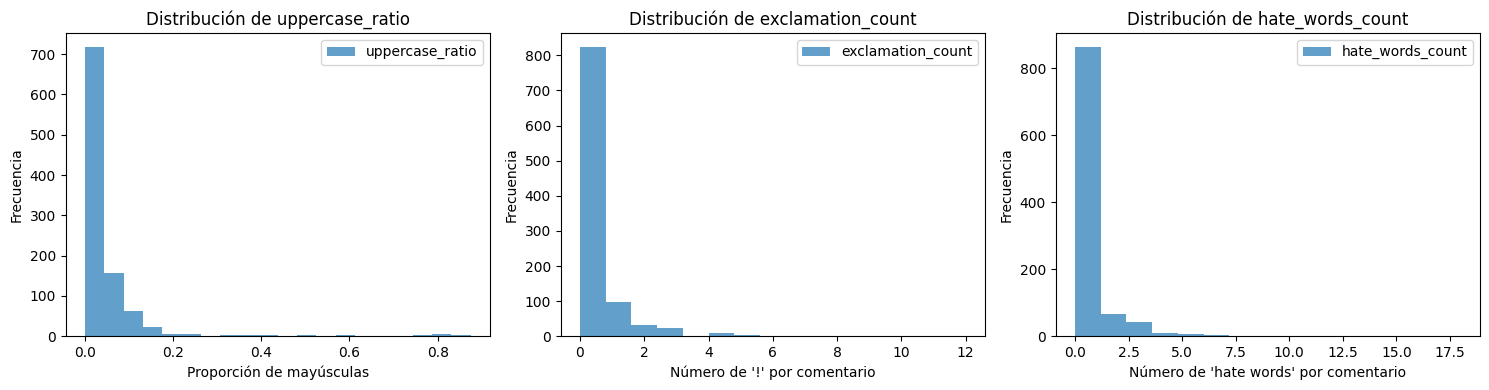


### 6. Features de estilo añadidas

En esta celda hemos calculado tres variables que capturan **cómo se escribe** el
comentario, no sólo *qué* se dice:

- `uppercase_ratio`:
  - Proporción de caracteres en mayúsculas.
  - Valores cercanos a 1 indican textos escritos casi todo en MAYÚSCULAS
    (suele asociarse a gritos o énfasis).
- `exclamation_count`:
  - Número de signos de exclamación `!` en el comentario.
  - Puede reflejar intensidad emocional.
- `hate_words_count`:
  - Conteo de un pequeño léxico de palabras de odio explícito
    (`fuck`, `idiot`, `hate`, `kill`, etc.).
  - Es un indicador sencillo pero útil de agresividad.

Los histogramas muestran:

- Que la mayoría de comentarios tienen **poca proporción de mayúsculas**,
  pero hay algunos outliers muy altos.
- Que normalmente hay **pocas exclamaciones**, pero aparecen comentarios con
  muchas `!`.
- Que la mayoría de comentarios tienen **pocas o ninguna hate word**, pero
  existe un subconjunto con varios términos ofensivos.

Estas features se pueden concatenar a los vectores de texto (por ejemplo TF-IDF)
en los modelos clásicos para capturar mejor el **tono** y no sólo el contenido.


In [6]:
# === 6. Extra style features ================================================
import matplotlib.pyplot as plt  # Plotting library for visual exploration

def compute_uppercase_ratio(text: str) -> float:
    """Compute ratio of uppercase letters in the text."""
    text = str(text)
    if len(text) == 0:
        return 0.0
    upper = sum(1 for c in text if c.isupper())
    return upper / len(text)


def count_exclamations(text: str) -> int:
    """Count exclamation marks in the text."""
    return str(text).count("!")


# Very simple explicit hate lexicon (can be extended)
HATE_WORDS = [
    "fuck", "shit", "damn", "idiot", "stupid",
    "hate", "kill", "die", "ass", "bitch",
    "crap", "garbage", "suck", "fucking"
]

def count_hate_words(text: str) -> int:
    """Count occurrences of simple hate words in the text (case-insensitive)."""
    text_low = str(text).lower()
    return sum(text_low.count(hw) for hw in HATE_WORDS)


# Compute features
df["uppercase_ratio"] = df["Text"].apply(compute_uppercase_ratio)
df["exclamation_count"] = df["Text"].apply(count_exclamations)
df["hate_words_count"] = df["Text"].apply(count_hate_words)

# Descriptive statistics for quick numeric overview
style_stats = df[["uppercase_ratio", "exclamation_count", "hate_words_count"]].describe()
print("📊 Descriptive statistics for style features:")
display(style_stats)

# Visual exploration with histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram: uppercase_ratio
axes[0].hist(df["uppercase_ratio"], bins=20, alpha=0.7)
axes[0].set_title("Distribución de uppercase_ratio")
axes[0].set_xlabel("Proporción de mayúsculas")
axes[0].set_ylabel("Frecuencia")
axes[0].legend(["uppercase_ratio"])

# Histogram: exclamation_count
axes[1].hist(df["exclamation_count"], bins=15, alpha=0.7)
axes[1].set_title("Distribución de exclamation_count")
axes[1].set_xlabel("Número de '!' por comentario")
axes[1].set_ylabel("Frecuencia")
axes[1].legend(["exclamation_count"])

# Histogram: hate_words_count
axes[2].hist(df["hate_words_count"], bins=15, alpha=0.7)
axes[2].set_title("Distribución de hate_words_count")
axes[2].set_xlabel("Número de 'hate words' por comentario")
axes[2].set_ylabel("Frecuencia")
axes[2].legend(["hate_words_count"])

plt.tight_layout()
plt.show()

display(Markdown(r"""
### 6. Features de estilo añadidas

En esta celda hemos calculado tres variables que capturan **cómo se escribe** el
comentario, no sólo *qué* se dice:

- `uppercase_ratio`:
  - Proporción de caracteres en mayúsculas.
  - Valores cercanos a 1 indican textos escritos casi todo en MAYÚSCULAS
    (suele asociarse a gritos o énfasis).
- `exclamation_count`:
  - Número de signos de exclamación `!` en el comentario.
  - Puede reflejar intensidad emocional.
- `hate_words_count`:
  - Conteo de un pequeño léxico de palabras de odio explícito
    (`fuck`, `idiot`, `hate`, `kill`, etc.).
  - Es un indicador sencillo pero útil de agresividad.

Los histogramas muestran:

- Que la mayoría de comentarios tienen **poca proporción de mayúsculas**,
  pero hay algunos outliers muy altos.
- Que normalmente hay **pocas exclamaciones**, pero aparecen comentarios con
  muchas `!`.
- Que la mayoría de comentarios tienen **pocas o ninguna hate word**, pero
  existe un subconjunto con varios términos ofensivos.

Estas features se pueden concatenar a los vectores de texto (por ejemplo TF-IDF)
en los modelos clásicos para capturar mejor el **tono** y no sólo el contenido.
"""))


### 7. Exploración visual de las *features* numéricas añadidas para modelado mediante **gráficos de dispersión (scatter plots)** coloreados por la etiqueta `IsToxic`
 
En esta sección:

- Exploramos visualmente las **features numéricas** generadas durante el preprocesado:
  - `text_len_classic` → longitud del comentario en caracteres.
  - `word_count_classic` → número de palabras del comentario.
  - `uppercase_ratio` → proporción de letras en mayúsculas en el texto.
  - `exclamation_count` → número de signos de exclamación `!`.
  - `hate_words_count` → número de palabras de odio detectadas en el comentario.
- Coloreamos los puntos por la etiqueta `IsToxic` (comentario tóxico vs no tóxico).

- Los gráficos son:
  1. Longitud en caracteres vs número de palabras.
  2. Proporción de mayúsculas vs número de exclamaciones.
  3. Número de palabras de odio vs longitud en palabras.


Estos gráficos:

- No modifican el dataset ni el preprocesado.
- Nos ayudan a entender si estas variables pueden ayudar a **separar** comentarios tóxicos de no tóxicos.
- Son útiles para **cualquier modelo** que use estas features (Naive Bayes, Regresión Logística, SVM, etc.).


✅ Todas las features numéricas necesarias están presentes en el DataFrame.

📌 Filas originales del dataset: 997
📌 Filas usadas para los gráficos: 997

📊 Conteo por etiqueta (target_label):
target_label
No tóxico    538
Tóxico       459
Name: count, dtype: int64


### 📊 Exploración visual de las *features* numéricas

#### 1. Longitud del texto vs número de palabras

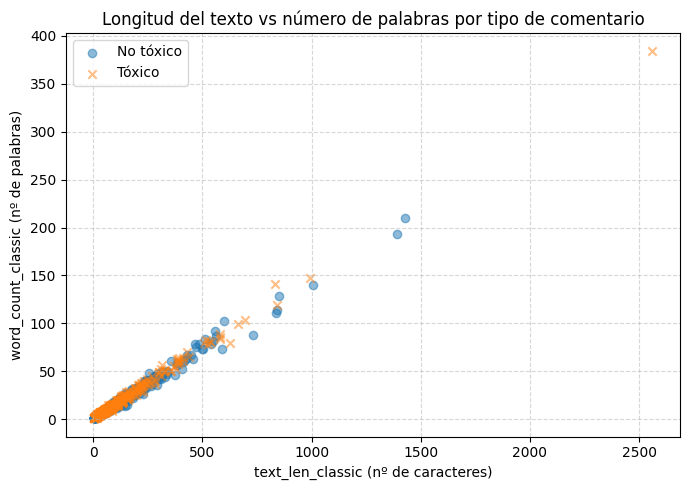

*Interpretación*: este gráfico muestra si los comentarios tóxicos tienden a ser más largos o más cortos que los no tóxicos, tanto en caracteres como en número de palabras.

#### 2. Proporción de mayúsculas vs número de exclamaciones

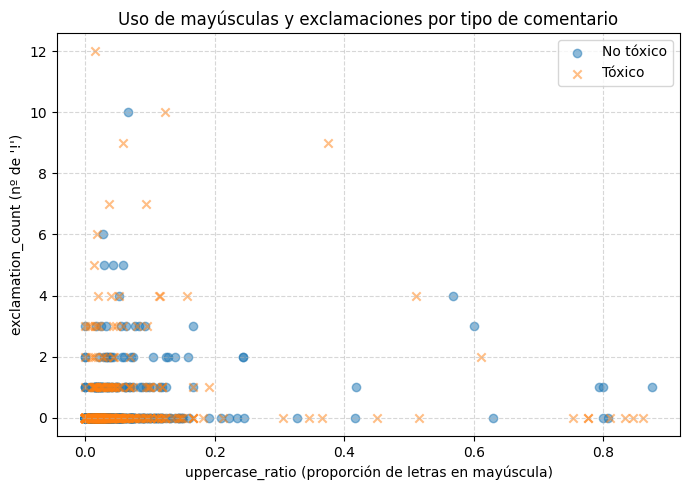

*Interpretación*: si los comentarios tóxicos se concentran en zonas con más mayúsculas y más exclamaciones, estas variables pueden ser buenos indicadores de tono agresivo.

#### 3. Palabras de odio vs longitud en palabras

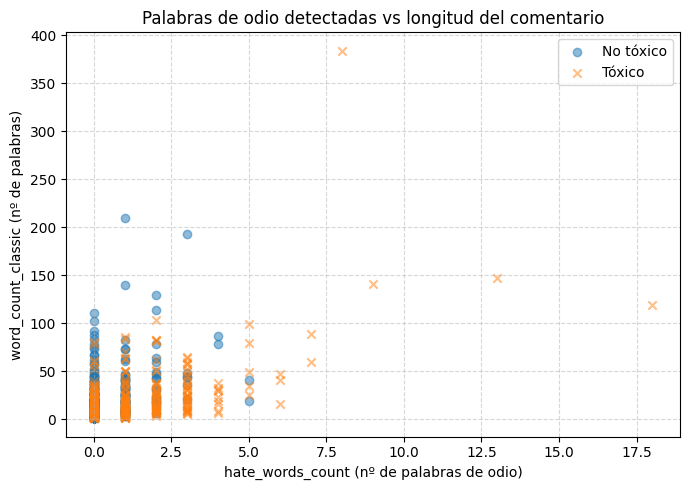

*Interpretación*: si la mayoría de los comentarios tóxicos tienen `hate_words_count > 0`, esta feature será especialmente útil para ayudar a los modelos a discriminar mejor entre tóxico y no tóxico.

In [7]:
# === 7. Quick visual exploration of numeric features =========================


# -----------------------------------------------------------------------------
# 1) Define numeric features and check they exist
# -----------------------------------------------------------------------------

numeric_features = [
    "text_len_classic",
    "word_count_classic",
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count",
]

# df is the main preprocessed DataFrame that already contains numeric features
missing_cols = [col for col in numeric_features if col not in df.columns]
if missing_cols:
    print("⚠️ Faltan las siguientes columnas numéricas en el DataFrame:", missing_cols)
else:
    print("✅ Todas las features numéricas necesarias están presentes en el DataFrame.")

# -----------------------------------------------------------------------------
# 2) Build DataFrame for plotting (numeric features + target label)
# -----------------------------------------------------------------------------

TARGET_COL = "IsToxic"  # We know this exists in the dataset

cols_for_plot = numeric_features + [TARGET_COL]

plot_df = df[cols_for_plot].dropna().copy()

print(f"\n📌 Filas originales del dataset: {df.shape[0]}")
print(f"📌 Filas usadas para los gráficos: {plot_df.shape[0]}")

# Map target to human-readable labels (handle booleans properly)
if plot_df[TARGET_COL].dtype == bool:
    # If the target is boolean (True/False)
    plot_df["target_label"] = np.where(
        plot_df[TARGET_COL],
        "Tóxico",
        "No tóxico",
    )
else:
    # If the target is 0/1 or similar
    plot_df["target_label"] = plot_df[TARGET_COL].map(
        {0: "No tóxico", 1: "Tóxico"}
    )

print("\n📊 Conteo por etiqueta (target_label):")
print(plot_df["target_label"].value_counts(dropna=False))

display(Markdown("### 📊 Exploración visual de las *features* numéricas"))


# -----------------------------------------------------------------------------
# 3) Helper function to create scatter plots
# -----------------------------------------------------------------------------
def scatter_by_target(
    x_col: str,
    y_col: str,
    title: str,
    xlabel: str,
    ylabel: str,
) -> None:
    """
    Create a scatter plot for two numeric features colored by target label.
    """
    plt.figure(figsize=(7, 5))
    
    # Non-toxic comments
    subset_non_toxic = plot_df[plot_df["target_label"] == "No tóxico"]
    plt.scatter(
        subset_non_toxic[x_col],
        subset_non_toxic[y_col],
        alpha=0.5,
        label="No tóxico",
        marker="o",
    )
    
    # Toxic comments
    subset_toxic = plot_df[plot_df["target_label"] == "Tóxico"]
    plt.scatter(
        subset_toxic[x_col],
        subset_toxic[y_col],
        alpha=0.5,
        label="Tóxico",
        marker="x",
    )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# 4) Plot 1: text_len_classic vs word_count_classic
# -----------------------------------------------------------------------------
display(Markdown("#### 1. Longitud del texto vs número de palabras"))

scatter_by_target(
    x_col="text_len_classic",
    y_col="word_count_classic",
    title="Longitud del texto vs número de palabras por tipo de comentario",
    xlabel="text_len_classic (nº de caracteres)",
    ylabel="word_count_classic (nº de palabras)",
)

display(Markdown(
    "*Interpretación*: este gráfico muestra si los comentarios tóxicos tienden "
    "a ser más largos o más cortos que los no tóxicos, tanto en caracteres como "
    "en número de palabras."
))

# -----------------------------------------------------------------------------
# 5) Plot 2: uppercase_ratio vs exclamation_count
# -----------------------------------------------------------------------------
display(Markdown("#### 2. Proporción de mayúsculas vs número de exclamaciones"))

scatter_by_target(
    x_col="uppercase_ratio",
    y_col="exclamation_count",
    title="Uso de mayúsculas y exclamaciones por tipo de comentario",
    xlabel="uppercase_ratio (proporción de letras en mayúscula)",
    ylabel="exclamation_count (nº de '!')",
)

display(Markdown(
    "*Interpretación*: si los comentarios tóxicos se concentran en zonas con "
    "más mayúsculas y más exclamaciones, estas variables pueden ser buenos "
    "indicadores de tono agresivo."
))

# -----------------------------------------------------------------------------
# 6) Plot 3: hate_words_count vs word_count_classic
# -----------------------------------------------------------------------------
display(Markdown("#### 3. Palabras de odio vs longitud en palabras"))

scatter_by_target(
    x_col="hate_words_count",
    y_col="word_count_classic",
    title="Palabras de odio detectadas vs longitud del comentario",
    xlabel="hate_words_count (nº de palabras de odio)",
    ylabel="word_count_classic (nº de palabras)",
)

display(Markdown(
    "*Interpretación*: si la mayoría de los comentarios tóxicos tienen "
    "`hate_words_count > 0`, esta feature será especialmente útil para "
    "ayudar a los modelos a discriminar mejor entre tóxico y no tóxico."
))


### 8. Selección de etiquetas y eliminación de columnas poco informativas

No todas las columnas `Is...` aportan información útil:

- Algunas están **siempre a `False`**.
- Otras tienen muy pocos valores `True` (por ejemplo, menos de 10).

En esta sección:

- Detectamos columnas constantes o casi vacías.
- Las eliminamos del dataset limpio.
- Dejamos sólo las etiquetas con suficientes ejemplos positivos.


In [8]:
# === 8. Select useful label columns =========================================

label_cols = [c for c in df.columns if c.startswith("Is")]
total_rows = len(df)

label_pos_counts = df[label_cols].sum().sort_values(ascending=False)
label_pos_df = pd.DataFrame({
    "Label": label_pos_counts.index,
    "Positives": label_pos_counts.values,
    "PosPercent": (label_pos_counts.values / total_rows) * 100
})

print("📊 Positives per label:")
display(label_pos_df)

# Define threshold for "too rare" labels
MIN_POS_THRESHOLD = 10

# Columns with all values equal (constant)
constant_cols = [c for c in label_cols if df[c].nunique() == 1]

# Columns with very few positives (< MIN_POS_THRESHOLD)
rare_cols = [c for c in label_cols if df[c].sum() < MIN_POS_THRESHOLD]

cols_to_drop = sorted(set(constant_cols + rare_cols))
cols_to_keep = [c for c in label_cols if c not in cols_to_drop]

print("\n❌ Label columns to drop (constant or too few positives):")
print(cols_to_drop)

print("\n✅ Label columns to keep:")
print(cols_to_keep)

display(Markdown(rf"""
### 8. Resultados: selección de etiquetas

- Total de columnas de etiqueta (`Is...`): **{len(label_cols)}**.
- Columnas con todos sus valores iguales (constantes):  
  `{constant_cols}`
- Columnas con menos de **{MIN_POS_THRESHOLD}** casos positivos:  
  `{rare_cols}`

Estas columnas se eliminan porque:

- No ayudan a entrenar modelos robustos (sin variabilidad o casi sin ejemplos).
- Aumentan complejidad sin aportar señal.

Las etiquetas que **mantenemos** son:

- `{cols_to_keep}`

Estas serán las que usemos en los notebooks de vectorización y modelado.
"""))

# Drop useless label columns
df = df.drop(columns=cols_to_drop)


📊 Positives per label:


,Label,Positives,PosPercent
0,IsToxic,459,46.038114
1,IsAbusive,350,35.105316
2,IsProvocative,158,15.847543
3,IsHatespeech,138,13.841525
4,IsRacist,125,12.537613
5,IsObscene,100,10.030090
6,IsThreat,21,2.106319
7,IsReligiousHate,12,1.203611
8,IsNationalist,8,0.802407
9,IsSexist,1,0.100301



❌ Label columns to drop (constant or too few positives):
['IsHomophobic', 'IsNationalist', 'IsRadicalism', 'IsSexist']

✅ Label columns to keep:
['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsReligiousHate']



### 8. Resultados: selección de etiquetas

- Total de columnas de etiqueta (`Is...`): **12**.
- Columnas con todos sus valores iguales (constantes):  
  `['IsHomophobic', 'IsRadicalism']`
- Columnas con menos de **10** casos positivos:  
  `['IsNationalist', 'IsSexist', 'IsHomophobic', 'IsRadicalism']`

Estas columnas se eliminan porque:

- No ayudan a entrenar modelos robustos (sin variabilidad o casi sin ejemplos).
- Aumentan complejidad sin aportar señal.

Las etiquetas que **mantenemos** son:

- `['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsReligiousHate']`

Estas serán las que usemos en los notebooks de vectorización y modelado.


### 9. Guardado del dataset limpio

Guardamos el dataset procesado en:

- `data/youtoxic_english_1000_clean.csv`

Este fichero incluye:

- Texto original (`Text`).
- Texto limpio para modelos modernos (`text_basic`).
- Texto limpio para modelos clásicos (`text_classic`).
- Features numéricas (`text_len_classic`, `word_count_classic`, estilos, etc.).
- Sólo las etiquetas `Is...` que aportan información.


In [11]:
# === 9. Save clean dataset ===================================================

# -----------------------------------------------------------------------------
# 9.1 Pre-save verification
# -----------------------------------------------------------------------------
print("\n📋 Verificación previa al guardado")

# Columns to preview (texto + features numéricas principales)
preview_cols = [
    "CommentId",
    "Text",
    "text_basic",
    "text_classic",
    "text_len_classic",
    "word_count_classic",
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count",
]

# Filtrar solo las columnas que existen por seguridad
preview_cols = [c for c in preview_cols if c in df.columns]

print("\n🔍 Primeros 5 registros (preview de columnas clave):")
print(df[preview_cols].head(5))

# Resumen numérico de las features más importantes
numeric_cols = [
    "text_len_classic",
    "word_count_classic",
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count",
]
numeric_cols = [c for c in numeric_cols if c in df.columns]

print("\n📊 Resumen numérico de features:")
print(df[numeric_cols].describe().round(2))

# Verificación rápida de etiquetas binarias
label_cols = [c for c in df.columns if c.startswith("Is")]
print("\n🏷️ Resumen de etiquetas (conteo de True por columna):")
print(df[label_cols].sum().sort_values(ascending=False))


# -----------------------------------------------------------------------------
# 9.2 Save clean dataset
# -----------------------------------------------------------------------------

clean_dir = project_root / "data" / "preprocessing_data"
clean_dir.mkdir(parents=True, exist_ok=True)

clean_path = clean_dir / "youtoxic_english_1000_clean.csv"
df.to_csv(clean_path, index=False)

display(Markdown(rf"""
### 9. Dataset limpio guardado

Se ha guardado el dataset procesado en:

- **`{clean_path}`**

Filas finales: **{len(df)}**  
Columnas finales: **{len(df.columns)}**

Este es el fichero que utilizaremos en los notebooks de:

1. **Vectorización** (TF-IDF, embeddings, etc.).
2. **Modelado clásico** (Regresión logística, Naive Bayes, SVM...).
3. **Modelos modernos** (BERT y variantes), utilizando principalmente `text_basic`.

Incluye:

- Texto original: `Text`
- Texto limpio para modelos modernos: `text_basic`
- Texto limpio para modelos clásicos: `text_classic`
- Features numéricas: `text_len_classic`, `word_count_classic`, `uppercase_ratio`, `exclamation_count`, `hate_words_count`, etc.
- Sólo las columnas de etiquetas `Is...` que aportan información.

"""))



📋 Verificación previa al guardado

🔍 Primeros 5 registros (preview de columnas clave):
              CommentId                                               Text  \
0  Ugg2KwwX0V8-aXgCoAEC  If only people would just take a step back and...   
1  Ugg2s5AzSPioEXgCoAEC  Law enforcement is not trained to shoot to app...   
2  Ugg3dWTOxryFfHgCoAEC  \r\nDont you reckon them 'black lives matter' ...   
3  Ugg7Gd006w1MPngCoAEC  There are a very large number of people who do...   
4  Ugg8FfTbbNF8IngCoAEC  The Arab dude is absolutely right, he should h...   

                                          text_basic  \
0  If only people would just take a step back and...   
1  Law enforcement is not trained to shoot to app...   
2  Dont you reckon them 'black lives matter' bann...   
3  There are a very large number of people who do...   
4  The Arab dude is absolutely right, he should h...   

                                        text_classic  text_len_classic  \
0  people would take step back m


### 9. Dataset limpio guardado

Se ha guardado el dataset procesado en:

- **`c:\Users\yeder\Documents\Factoria F5 Bootcamp IA\Proyecto_X_NLP_G4\data\preprocessing_data\youtoxic_english_1000_clean.csv`**

Filas finales: **997**  
Columnas finales: **18**

Este es el fichero que utilizaremos en los notebooks de:

1. **Vectorización** (TF-IDF, embeddings, etc.).
2. **Modelado clásico** (Regresión logística, Naive Bayes, SVM...).
3. **Modelos modernos** (BERT y variantes), utilizando principalmente `text_basic`.

Incluye:

- Texto original: `Text`
- Texto limpio para modelos modernos: `text_basic`
- Texto limpio para modelos clásicos: `text_classic`
- Features numéricas: `text_len_classic`, `word_count_classic`, `uppercase_ratio`, `exclamation_count`, `hate_words_count`, etc.
- Sólo las columnas de etiquetas `Is...` que aportan información.



### 10. Resumen final del preprocesamiento


In [10]:
# === 10. Final preprocessing summary =========================================

n_rows_final = len(df)
n_cols_final = len(df.columns)

display(Markdown(rf"""
--------------------------------------------------
✅ PREPROCESAMIENTO COMPLETADO
--------------------------------------------------

**Tamaño final del dataset limpio**

- Filas: **{n_rows_final}**
- Columnas: **{n_cols_final}**

**Transformaciones aplicadas**

1. ✓ Eliminación de textos duplicados.
2. ✓ Limpieza básica del texto (`text_basic`):
   - Menciones, hashtags, saltos de línea.
   - Emojis convertidos a texto.
3. ✓ Normalización avanzada y texto clásico (`text_classic`):
   - Minúsculas, sin números ni puntuación.
   - Stopwords en inglés eliminadas.
   - Lematización (WordNet).
4. ✓ Features numéricas:
   - `text_len_classic`, `word_count_classic`.
   - `uppercase_ratio`, `exclamation_count`, `hate_words_count`.
5. ✓ Selección de etiquetas `Is...`:
   - Eliminadas columnas constantes o con menos de 10 positivos.
   - Conservadas sólo etiquetas útiles para modelado.

**Siguientes pasos (en otros notebooks)**

1. 🧹 **Vectorización**  
   - TF-IDF con uni-gramas y bi-gramas.
   - Opcional: embeddings (Word2Vec, FastText, BERT).

2. 🤖 **Modelado**  
   - Baseline: Regresión logística, Naive Bayes.
   - Avanzado: Random Forest, XGBoost, SVM.
   - Deep Learning: LSTM, fine-tuning de BERT.

3. 📊 **Evaluación**  
   - Precision, Recall, F1-Score (macro y por etiqueta).
   - Matrices de confusión por tipo de odio.
   - Análisis de errores.

4. 🚀 **Productivización**  
   - API con FastAPI.
   - Interfaz con Streamlit.
   - Dockerización.

**Advertencias importantes**

- Dataset relativamente pequeño → modelos simples pueden generalizar mejor.
- No usar *accuracy* como métrica principal → centrarse en **F1** y **recall**.
- Problema **multi-label** → decidir si usar un modelo por etiqueta o uno multi-label.
- Idioma:
  - Este pipeline está pensado para inglés.
  - Para español, habría que:
    - Cambiar stopwords a `'spanish'`.
    - Usar stemming/lematización específicos (Snowball, spaCy, etc.).
"""))



--------------------------------------------------
✅ PREPROCESAMIENTO COMPLETADO
--------------------------------------------------

**Tamaño final del dataset limpio**

- Filas: **997**
- Columnas: **18**

**Transformaciones aplicadas**

1. ✓ Eliminación de textos duplicados.
2. ✓ Limpieza básica del texto (`text_basic`):
   - Menciones, hashtags, saltos de línea.
   - Emojis convertidos a texto.
3. ✓ Normalización avanzada y texto clásico (`text_classic`):
   - Minúsculas, sin números ni puntuación.
   - Stopwords en inglés eliminadas.
   - Lematización (WordNet).
4. ✓ Features numéricas:
   - `text_len_classic`, `word_count_classic`.
   - `uppercase_ratio`, `exclamation_count`, `hate_words_count`.
5. ✓ Selección de etiquetas `Is...`:
   - Eliminadas columnas constantes o con menos de 10 positivos.
   - Conservadas sólo etiquetas útiles para modelado.

**Siguientes pasos (en otros notebooks)**

1. 🧹 **Vectorización**  
   - TF-IDF con uni-gramas y bi-gramas.
   - Opcional: embeddings (Word2Vec, FastText, BERT).

2. 🤖 **Modelado**  
   - Baseline: Regresión logística, Naive Bayes.
   - Avanzado: Random Forest, XGBoost, SVM.
   - Deep Learning: LSTM, fine-tuning de BERT.

3. 📊 **Evaluación**  
   - Precision, Recall, F1-Score (macro y por etiqueta).
   - Matrices de confusión por tipo de odio.
   - Análisis de errores.

4. 🚀 **Productivización**  
   - API con FastAPI.
   - Interfaz con Streamlit.
   - Dockerización.

**Advertencias importantes**

- Dataset relativamente pequeño → modelos simples pueden generalizar mejor.
- No usar *accuracy* como métrica principal → centrarse en **F1** y **recall**.
- Problema **multi-label** → decidir si usar un modelo por etiqueta o uno multi-label.
- Idioma:
  - Este pipeline está pensado para inglés.
  - Para español, habría que:
    - Cambiar stopwords a `'spanish'`.
    - Usar stemming/lematización específicos (Snowball, spaCy, etc.).
